# Sessió 3: PyTorch & Classificació Avançada

## **NOM**: Ona Sánchez Núñez####

## **NIU**: 1601181####

En aquesta sessió continuarem utilitzant pytorch per definir i evaluar diferents models amb xarxes neuronals.

* Durant la classe, repasarem el codi aqui mostrat i veurem què podem provar.
* **A casa**
 * Definir models i entrenar-los (5pts)
 * Mostrar corbes de aprenentatge (2pts)
 * Mostrar models, parametres, flops teorics i temps real dels models (3pts)

Treballarem sobre la base de dades [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). És similar a la base de dades de MNIST, un dataset clàssic en la visió per computador. Són imatges de 28x28 pixels i en escala de grisos. El original disposa de 60.000 imatges de entrenament i 10.000 de test. Està anotat en 10 categories diferents:

|Id|Nom|
|:-:|:--|
|0|T-shirt/top
|1|Trouser |
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag |
|9|Ankle boot|

<img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png" width="60%">


### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import tqdm
import sys
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Parameters

Aqui definim els principals parametres que poden fer variar el metode

In [2]:
quick_experiment = False  # reduce the number of training and testing samples for a quick check
epochs_in_quick = 3      # number of epochs in the fast experiment
n_train_in_quick = 600  # number of training images in the fast experiment
n_test_in_quick = 1000    # number of testing images in the fast experiment

#epochs = 5             # number of epochs to train (default: 14)
learning_rate = 0.001   # learning rate (default: 0.001-[0.01]-0.1)

Si fem un experiment rapid, quin % del total estem agafant:

In [3]:
total_training_data = 60000 # no tocar. només serveix per visualitzar
total_testing_data = 10000  # no tocar. només serveix per visualitzar

print("TRAINING USED:  {:.1f}%\nTESTING  USED:  {:.1f}%".format(100.*n_train_in_quick/total_training_data, 
                                                                100.*n_test_in_quick/total_testing_data))

TRAINING USED:  1.0%
TESTING  USED:  10.0%


En principi els següents parametres son força estandard i no caldria tocar-los gaire si no sabeu el que volen dir.

In [4]:
batch_size = 100        # number of samples during training
test_batch_size = 1000  # number of samples for test 

no_cuda = True          # disables CUDA training
dry_run = False         # quickly check a single pass
seed = 1                # random seed (default: 1)
log_interval = 50       # how many batches to wait before logging training status
save_model = False      # For Saving the current Model


# Check if cuda is available
use_cuda = not no_cuda and torch.cuda.is_available()
print(f"USING CUDA: {use_cuda}")
torch.manual_seed(seed)

# define the device where to compute (cpu or gpu)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


USING CUDA: False


### Models

In [5]:
class Net_Linear(nn.Module):
    def __init__(self):
        super(Net_Linear, self).__init__()
        self.w = nn.Linear(784, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        output = self.w(x)
        return F.log_softmax(output, dim=1)


class LeNet_tiny(nn.Module):
    def __init__(self):
        super(LeNet_tiny, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2304, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

### Models a definir

In [6]:
class my_model_1(nn.Module):
    def __init__(self):
        super(my_model_1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.Tanh(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 6 * 6, 600),
            nn.Tanh())
        self.fc2= nn.Sequential(
            nn.Linear(600, 120))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)

        return out


class my_model_2(nn.Module):
    def __init__(self):
        super(my_model_2, self).__init__()
        self.w = nn.LazyLinear(784, 10)
  
    def forward(self, x):
        x = torch.flatten(x, 1)
        output = self.w(x)
        return F.log_softmax(output, dim=1)


class my_model_3(nn.Module):
    def __init__(self):
        super(my_model_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2304, 32)
        self.dropout3 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


## **Model 1** ####
S'ha usat una combinació del model FashionCNN (ja que tenia una accuracy bastant elevada), amb la inicialització del model AlexNet buscat per internet, per tal de veure si cambiant la inicialització del model la precisió augmentava o disminuia.

## **Model 2**####
S'ha observat que el model amb una accuracy més elevada dels que es disposava originalment era el Net_Linear, pel que s'ha intentat millorar l'accuracy d'aquest utilitzant LazyLinear enlloc de Linear per inicialitzar self.w.

## **Model 3**####
S'ha estudiat el model LeNet i s'ha volgut provar que passaria si s'usés una diferent funció d'activació (la sigmoid enlloc de relu), i combinant-ho amb diversos dropouts en la inicialització del model. Tot i que per la funció sigmoidea no s'espera obtenir una precisió molt elevada, s'ha usat per veure que tant afecta al model un canvi de funció d'activació i com canvia la precissió de les prediccions.

### Funcions auxiliars

In [7]:
def visualize_confusion_matrix(y_pred, y_real):
    # mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def calcular_parametres_del_model(current_model):
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("# trainable parameters: {:,}".format(pytorch_total_params))
    return pytorch_total_params

def calculate_parameters_and_flops(current_model):
    from thop import profile
    test_input = torch.randn(1, 1, 28, 28)
    macs, params = profile(current_model, inputs=(test_input,))  # multiply accumulate operation (GFLOPS = 2 * GMACS)
    # normalment, en gpus i exemples reals, es parlaria minim de Gigaflops.
    # print("%s | %.2f Params(M) | %.3f FLOPs(G)" % (current_model._get_name(), params / (1000 ** 2), macs / (1000 ** 3)))
    print("%s | %.2f Params(M) | %.3f FLOPs(M)" % (current_model._get_name(), params / (1000 ** 2), macs / (1000 ** 2)))
    return macs, params
    
def mostra_estructura_model_torchviz(current_model):
    from torchviz import make_dot
    test_input = torch.randn(1, 1, 28, 28)
    return make_dot(current_model(test_input), params=dict(current_model.named_parameters()))
    
def mostra_estructura_model_hiddenlayer(current_model):
    import hiddenlayer as hl
    test_input = torch.randn(1, 1, 28, 28)
    hl_graph = hl.build_graph(current_model, test_input)
    return hl_graph



### Train loop

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    t = tqdm.tqdm(enumerate(train_loader), total=len(train_loader))
    t.set_description('Train')
    for batch_idx, (data, target) in t:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        t.set_postfix(loss=loss.item())

    return losses

### Test loop

In [9]:
def test(model, device, test_loader, criterion, epoch, show_confusion_matrix=True):
    model.eval()
    test_loss = 0
    correct = 0
    totals = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        t = tqdm.tqdm(test_loader, total=len(test_loader))
        t.set_description('Test ')
        for data, target in t:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.shape[0]  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            totals += len(target)
            t.set_postfix(loss=test_loss/totals, accuracy=100.*correct/totals)
            all_preds.extend(np.asarray(pred))
            all_targets.extend(np.asarray(target))

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # visualize confusion matrix?
    if show_confusion_matrix and epoch == epochs:
        visualize_confusion_matrix(all_targets, all_preds)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    return test_loss, accuracy

### Preparar les dades d'entrenament

In [10]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
dataset_train = torchvision.datasets.FashionMNIST('../data', train=True, download=True, transform=transform)
dataset_val = torchvision.datasets.FashionMNIST('../data', train=False, transform=transform)

if quick_experiment:
    epochs = epochs_in_quick
    n_not_used_for_train_in_quick = len(dataset_train) - n_train_in_quick
    dataset_train, dataset_train_not_used = torch.utils.data.random_split(dataset_train,
                                                                          [n_train_in_quick,
                                                                           n_not_used_for_train_in_quick])

    n_not_used_for_test_in_quick = len(dataset_val) - n_test_in_quick
    dataset_val, dataset_val_not_used = torch.utils.data.random_split(dataset_val,
                                                                          [n_test_in_quick,
                                                                           n_not_used_for_test_in_quick])

train_loader = torch.utils.data.DataLoader(dataset_train, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset_val, **test_kwargs)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



### Experiment Loop

In [11]:
def experiment(model, device, loss, optimizer, train_loader, test_loader, name='', save_model=False):
    init_time = time.time()
    losses_train = []
    losses_test = []
    accuracies_test = []
    print('--'*50)
    print('STARTING EXPERIMENT {}'.format(name))
    print('--'*50)
    
    model.to(device)
    print("CHECKING INITIAL TEST LOSS (with random weights..)")
    # calculo aquest test tan sols per visualitzar més maca la gràfica de losses. No caldria utilitzar-lo
    loss_test_epoch, accuracy_epoch = test(model, device, test_loader, loss, 0)
    losses_test.append(loss_test_epoch)
    accuracies_test.append(accuracy_epoch)
    
    for epoch in range(1, epochs + 1):
        print ("EPOCH {}".format(epoch))
        sys.stdout.flush()
        loss_train_epoch = train(model, device, train_loader, optimizer, loss)
        loss_test_epoch, accuracy_epoch = test(model, device, test_loader, loss, epoch)

        losses_train.extend(loss_train_epoch)
        losses_test.append(loss_test_epoch)
        accuracies_test.append(accuracy_epoch)
    
    plt.plot(range(len(losses_train)), 
             losses_train, label="Training Loss")

    plt.plot(range(0, len(losses_train)+1, int(len(losses_train)/(len(losses_test)-1))), 
             losses_test, label="Test Loss")
    plt.legend()
    plt.show()
    
    elapsed = time.time()-init_time

    if save_model:
        torch.save(model.state_dict(), "fashion_mnist_cnn.pt")

    print ("ELAPSED TIME: {:.1f}s".format(elapsed))

    print("APARTAT C: MOSTRAR ELS MODELS")
    calcular_parametres_del_model(model)
    calculate_parameters_and_flops(model)
    mostra_estructura_model_torchviz(model)
    mostra_estructura_model_hiddenlayer(model)

    return losses_train, losses_test, accuracies_test, elapsed

### Instanciació d'un model

In [12]:
model = LeNet()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Fer un entrenament

In [13]:
model = LeNet()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_train, loss_test, acc_test, elapsed = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      name='EXP #1', 
                                                      save_model=False)

----------------------------------------------------------------------------------------------------
STARTING EXPERIMENT EXP #1
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)


Test : 100%|██████████| 10/10 [00:10<00:00,  1.03s/it, accuracy=12.8, loss=2.3]


NameError: ignored

----------------------------------------------------------------------------------------------------
STARTING EXPERIMENT EXP #2
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)


Test : 100%|██████████| 10/10 [00:02<00:00,  4.67it/s, accuracy=6.08, loss=2.47]


Test set: Average loss: 2.4666, Accuracy: 608/10000 (6.08%)

EPOCH 1



Test : 100%|██████████| 10/10 [00:02<00:00,  3.39it/s, accuracy=82.8, loss=0.487]


Test set: Average loss: 0.4874, Accuracy: 8285/10000 (82.85%)

EPOCH 2



Test : 100%|██████████| 10/10 [00:02<00:00,  4.79it/s, accuracy=83.3, loss=0.469]


Test set: Average loss: 0.4691, Accuracy: 8335/10000 (83.35%)

EPOCH 3



Test : 100%|██████████| 10/10 [00:02<00:00,  3.61it/s, accuracy=83.5, loss=0.463]


Test set: Average loss: 0.4631, Accuracy: 8348/10000 (83.48%)

EPOCH 4



Test : 100%|██████████| 10/10 [00:02<00:00,  4.95it/s, accuracy=83.6, loss=0.461]


Test set: Average loss: 0.4608, Accuracy: 8361/10000 (83.61%)

EPOCH 5



Test : 100%|██████████| 10/10 [00:02<00:00,  4.80it/s, accuracy=83.8, loss=0.46]


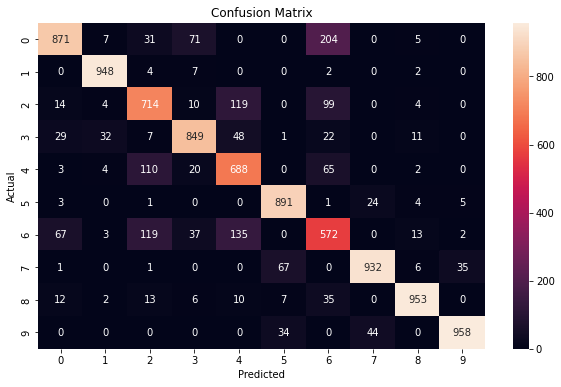


Test set: Average loss: 0.4600, Accuracy: 8376/10000 (83.76%)



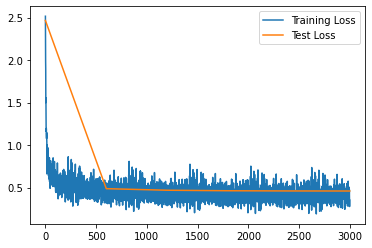

ELAPSED TIME: 105.6s
APARTAT C: MOSTRAR ELS MODELS
# trainable parameters: 7,850
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Net_Linear | 0.01 Params(M) | 0.008 FLOPs(M)


AttributeError: ignored

In [ ]:
model = Net_Linear()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train, loss_test, acc_test, elapsed = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      name='EXP #2', 
                                                      save_model=False)

----------------------------------------------------------------------------------------------------
STARTING EXPERIMENT EXP #3
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)


Test : 100%|██████████| 10/10 [00:03<00:00,  2.77it/s, accuracy=10.1, loss=2.31]


Test set: Average loss: 2.3063, Accuracy: 1013/10000 (10.13%)

EPOCH 1



Test : 100%|██████████| 10/10 [00:03<00:00,  2.74it/s, accuracy=83.2, loss=0.462]


Test set: Average loss: 0.4624, Accuracy: 8318/10000 (83.18%)

EPOCH 2



Test : 100%|██████████| 10/10 [00:03<00:00,  2.91it/s, accuracy=85.9, loss=0.397]


Test set: Average loss: 0.3974, Accuracy: 8586/10000 (85.86%)

EPOCH 3



Test : 100%|██████████| 10/10 [00:03<00:00,  2.76it/s, accuracy=86.6, loss=0.372]


Test set: Average loss: 0.3719, Accuracy: 8658/10000 (86.58%)

EPOCH 4



Test : 100%|██████████| 10/10 [00:03<00:00,  2.88it/s, accuracy=87.8, loss=0.343]


Test set: Average loss: 0.3432, Accuracy: 8780/10000 (87.80%)

EPOCH 5



Test : 100%|██████████| 10/10 [00:03<00:00,  2.91it/s, accuracy=88, loss=0.329]


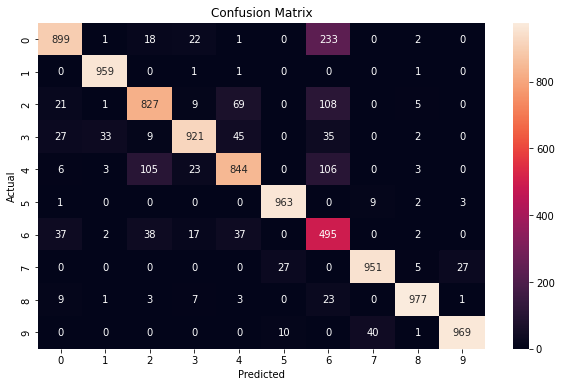


Test set: Average loss: 0.3285, Accuracy: 8805/10000 (88.05%)



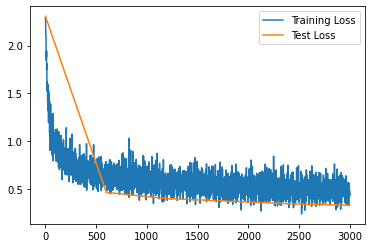

ELAPSED TIME: 224.6s
APARTAT C: MOSTRAR ELS MODELS
# trainable parameters: 75,338
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
LeNet_tiny | 0.08 Params(M) | 0.786 FLOPs(M)


AttributeError: ignored

In [ ]:
model = LeNet_tiny()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train, loss_test, acc_test, elapsed = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      name='EXP #3', 
                                                      save_model=False)

----------------------------------------------------------------------------------------------------
STARTING EXPERIMENT EXP #4
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)


Test :   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Test : 100%|██████████| 10/10 [00:07<00:00,  1.38it/s, accuracy=11.9, loss=2.29]


Test set: Average loss: 2.2885, Accuracy: 1194/10000 (11.94%)

EPOCH 1



Test : 100%|██████████| 10/10 [00:07<00:00,  1.39it/s, accuracy=88.1, loss=0.329]


Test set: Average loss: 0.3287, Accuracy: 8808/10000 (88.08%)

EPOCH 2



Test : 100%|██████████| 10/10 [00:07<00:00,  1.39it/s, accuracy=85.5, loss=0.42]


Test set: Average loss: 0.4201, Accuracy: 8549/10000 (85.49%)

EPOCH 3



Test : 100%|██████████| 10/10 [00:07<00:00,  1.39it/s, accuracy=86.6, loss=0.408]


Test set: Average loss: 0.4082, Accuracy: 8659/10000 (86.59%)

EPOCH 4



Test : 100%|██████████| 10/10 [00:07<00:00,  1.38it/s, accuracy=89.8, loss=0.308]


Test set: Average loss: 0.3079, Accuracy: 8983/10000 (89.83%)

EPOCH 5



Test : 100%|██████████| 10/10 [00:07<00:00,  1.40it/s, accuracy=90.4, loss=0.3]


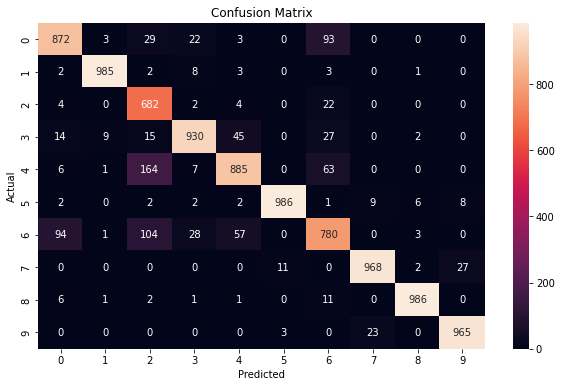


Test set: Average loss: 0.3003, Accuracy: 9039/10000 (90.39%)



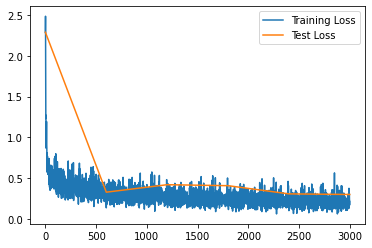

ELAPSED TIME: 603.2s
APARTAT C: MOSTRAR ELS MODELS
# trainable parameters: 1,475,338
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FashionCNN | 1.48 Params(M) | 4.473 FLOPs(M)


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


AttributeError: ignored

In [ ]:
model = FashionCNN()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train, loss_test, acc_test, elapsed = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      name='EXP #4', 
                                                      save_model=False)

----------------------------------------------------------------------------------------------------
STARTING EXPERIMENT EXP #5
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)


Test : 100%|██████████| 10/10 [00:08<00:00,  1.20it/s, accuracy=0.05, loss=4.84]


Test set: Average loss: 4.8401, Accuracy: 5/10000 (0.05%)

EPOCH 1



Test : 100%|██████████| 10/10 [00:08<00:00,  1.21it/s, accuracy=86.6, loss=0.358]


Test set: Average loss: 0.3583, Accuracy: 8661/10000 (86.61%)

EPOCH 2



Test : 100%|██████████| 10/10 [00:08<00:00,  1.20it/s, accuracy=89.3, loss=0.293]


Test set: Average loss: 0.2933, Accuracy: 8931/10000 (89.31%)

EPOCH 3



Test : 100%|██████████| 10/10 [00:08<00:00,  1.20it/s, accuracy=90, loss=0.273]


Test set: Average loss: 0.2733, Accuracy: 8995/10000 (89.95%)

EPOCH 4



Test : 100%|██████████| 10/10 [00:08<00:00,  1.20it/s, accuracy=91, loss=0.246]


Test set: Average loss: 0.2463, Accuracy: 9103/10000 (91.03%)

EPOCH 5



Test : 100%|██████████| 10/10 [00:08<00:00,  1.21it/s, accuracy=91.3, loss=0.236]


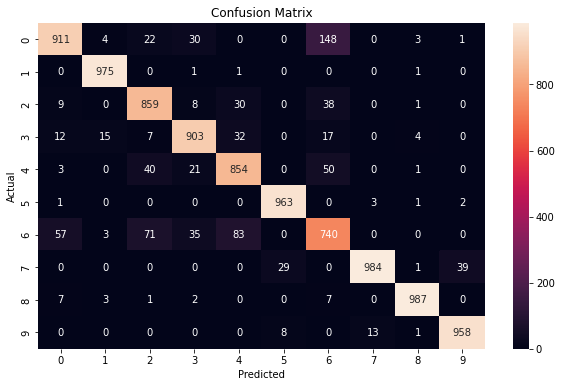


Test set: Average loss: 0.2356, Accuracy: 9134/10000 (91.34%)



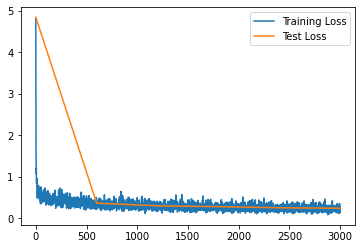

ELAPSED TIME: 633.9s
APARTAT C: MOSTRAR ELS MODELS
# trainable parameters: 1,474,128
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
my_model_1 | 1.47 Params(M) | 4.472 FLOPs(M)


AttributeError: ignored

In [ ]:
model = my_model_1()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train, loss_test, acc_test, elapsed = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      name='EXP #5', 
                                                      save_model=False)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------------------------------------------
STARTING EXPERIMENT EXP #6
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)


Test : 100%|██████████| 10/10 [00:02<00:00,  4.22it/s, accuracy=0.07, loss=7.17]


Test set: Average loss: 7.1743, Accuracy: 7/10000 (0.07%)

EPOCH 1



Test : 100%|██████████| 10/10 [00:02<00:00,  4.28it/s, accuracy=82.8, loss=0.494]


Test set: Average loss: 0.4944, Accuracy: 8278/10000 (82.78%)

EPOCH 2



Test : 100%|██████████| 10/10 [00:02<00:00,  4.31it/s, accuracy=83.3, loss=0.473]


Test set: Average loss: 0.4734, Accuracy: 8331/10000 (83.31%)

EPOCH 3



Test : 100%|██████████| 10/10 [00:03<00:00,  3.14it/s, accuracy=83.5, loss=0.466]


Test set: Average loss: 0.4660, Accuracy: 8350/10000 (83.50%)

EPOCH 4



Test : 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, accuracy=83.7, loss=0.463]


Test set: Average loss: 0.4628, Accuracy: 8365/10000 (83.65%)

EPOCH 5



Test : 100%|██████████| 10/10 [00:02<00:00,  4.02it/s, accuracy=83.8, loss=0.461]


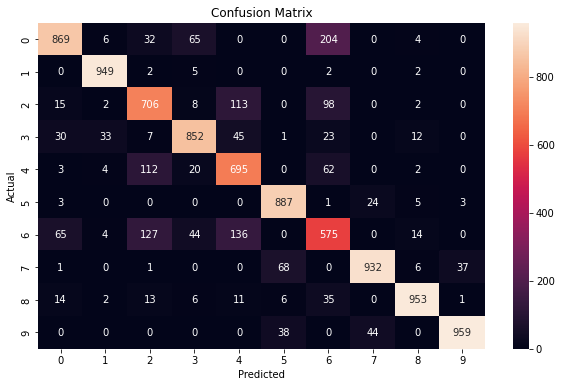


Test set: Average loss: 0.4613, Accuracy: 8377/10000 (83.77%)



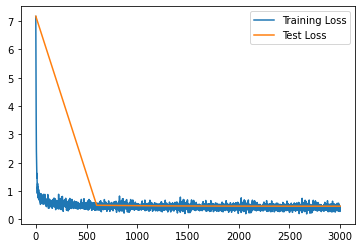

ELAPSED TIME: 132.8s
APARTAT C: MOSTRAR ELS MODELS
# trainable parameters: 615,440
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
my_model_2 | 0.62 Params(M) | 0.615 FLOPs(M)


AttributeError: ignored

In [ ]:
model = my_model_2()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train, loss_test, acc_test, elapsed = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      name='EXP #6', 
                                                      save_model=False)

----------------------------------------------------------------------------------------------------
STARTING EXPERIMENT EXP #7
----------------------------------------------------------------------------------------------------
CHECKING INITIAL TEST LOSS (with random weights..)


Test :   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Test : 100%|██████████| 10/10 [00:03<00:00,  2.61it/s, accuracy=10, loss=2.33]


Test set: Average loss: 2.3300, Accuracy: 1000/10000 (10.00%)

EPOCH 1



Test : 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, accuracy=74.5, loss=0.695]


Test set: Average loss: 0.6948, Accuracy: 7446/10000 (74.46%)

EPOCH 2



Test : 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, accuracy=79.9, loss=0.547]


Test set: Average loss: 0.5473, Accuracy: 7991/10000 (79.91%)

EPOCH 3



Test : 100%|██████████| 10/10 [00:03<00:00,  2.71it/s, accuracy=81.7, loss=0.501]


Test set: Average loss: 0.5012, Accuracy: 8166/10000 (81.66%)

EPOCH 4



Test : 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, accuracy=82.5, loss=0.464]


Test set: Average loss: 0.4638, Accuracy: 8246/10000 (82.46%)

EPOCH 5



Test : 100%|██████████| 10/10 [00:03<00:00,  2.68it/s, accuracy=83.9, loss=0.435]


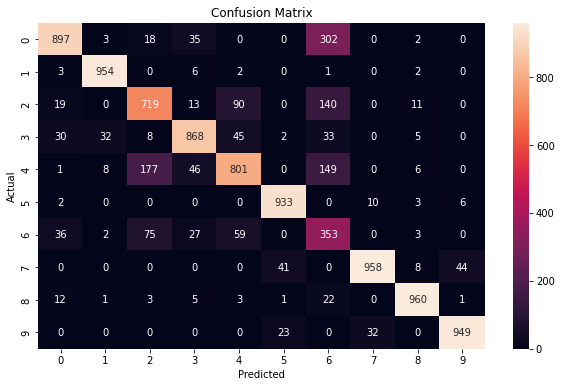


Test set: Average loss: 0.4347, Accuracy: 8392/10000 (83.92%)



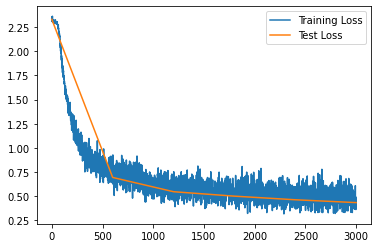

ELAPSED TIME: 241.1s
APARTAT C: MOSTRAR ELS MODELS
# trainable parameters: 75,338
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
my_model_3 | 0.08 Params(M) | 0.786 FLOPs(M)


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AttributeError: ignored

In [ ]:
model = my_model_3()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train, loss_test, acc_test, elapsed = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      name='EXP #7', 
                                                      save_model=False)

# Entrega

* A. Fes varis entrenaments amb diferents models.**(5pts)**
 * Utilitza els 4 models aqui definits.
 * **Defineix 3 nous models diferents, explica'ls i entrena'ls.** Pots crear-ne de simples, de més complexes, treure poolings o afegir-ne, modificar el percentatge de regularització del dropout, cambiar la funció d’activació, buscar altres definicions per Internet, altres tipus de capes, amb més o menys neurones per capa, capes residuals, provar d’agafar-ne alguna de pre-entrenada… Podeu provar altres configuracions d’entrenament, més o menys èpoques, diferent learning rate, diferent optimitzador, afegir weight_decay….


* B. **Mostra les corbes d'aprenentatge** de cadascún d'ells i compara-les amb les aquí definides. (7 en total) **(2pts)**
 * Per cada model, mostra la loss d'entrenament i la de test en una mateixa gráfica.
 * Mostra les matrius de confusió del model de la última època sobre el conjunt de test.
 
* C. **Mostra els models**, parametres, flops teorics i temps real dels models **(3pts)**
 * Us he deixat varies funcions que us mostren els models. Haureu d'instalar les llibreries corresponents: 
   * [thop](https://github.com/Lyken17/pytorch-OpCounter/) per mostrar parametres, flops..
   * [hiddenlayer](https://github.com/waleedka/hiddenlayer) i [torchviz](https://github.com/szagoruyko/pytorchviz). Per mostrar els graphs. Aquestes també requereixen tenir instalat ``graphviz``